./ESC-50-master/:
audio  esc50.gif  LICENSE  meta  pytest.ini  README.md	requirements.txt  tests

./ESC-50-master/audio:
1-100032-A-0.wav   2-100648-A-43.wav  3-100018-A-18.wav  4-102844-A-49.wav  5-103415-A-2.wav
1-100038-A-14.wav  2-100786-A-1.wav   3-100024-A-27.wav  4-102844-B-49.wav  5-103416-A-2.wav
1-100210-A-36.wav  2-101676-A-10.wav  3-100024-B-27.wav  4-102844-C-49.wav  5-103418-A-2.wav
1-100210-B-36.wav  2-102414-A-17.wav  3-101381-A-33.wav  4-102871-A-42.wav  5-103420-A-2.wav
1-101296-A-19.wav  2-102414-B-17.wav  3-101381-B-33.wav  4-107117-A-33.wav  5-103421-A-2.wav
1-101296-B-19.wav  2-102414-C-17.wav  3-102583-A-49.wav  4-107120-A-33.wav  5-103422-A-2.wav
1-101336-A-30.wav  2-102414-D-17.wav  3-102583-B-49.wav  4-107122-A-33.wav  5-117118-A-42.wav
1-101404-A-34.wav  2-102414-E-17.wav  3-102583-C-49.wav  4-108352-A-33.wav  5-117120-A-42.wav
1-103298-A-9.wav   2-102414-F-17.wav  3-102908-A-4.wav	 4-111671-A-42.wav  5-117122-A-42.wav
1-103995-A-30.wav  2-102414-G-17.wav  3-

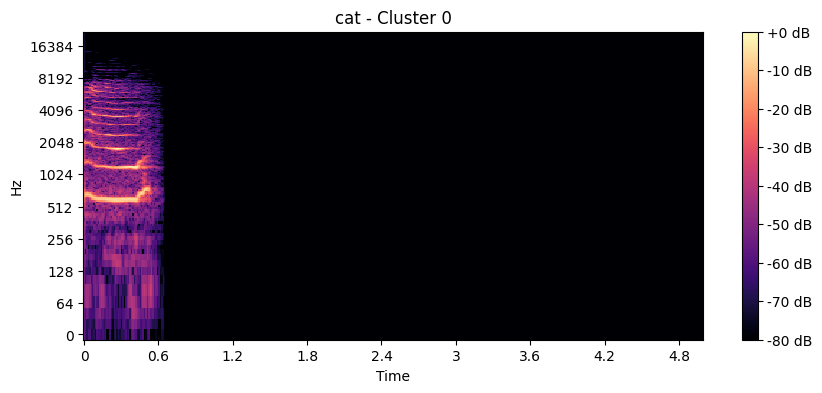

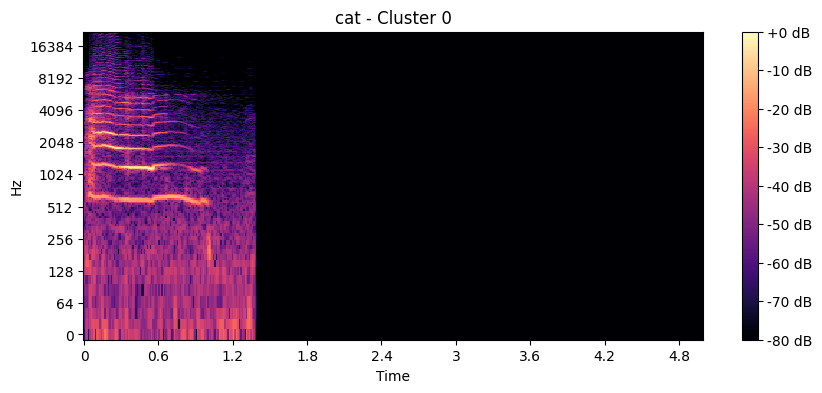

Cluster 1: ['dog' 'cat' 'chirping_birds']


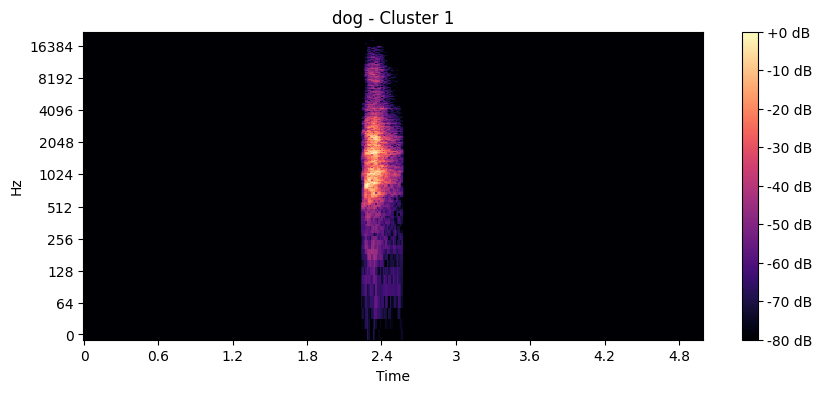

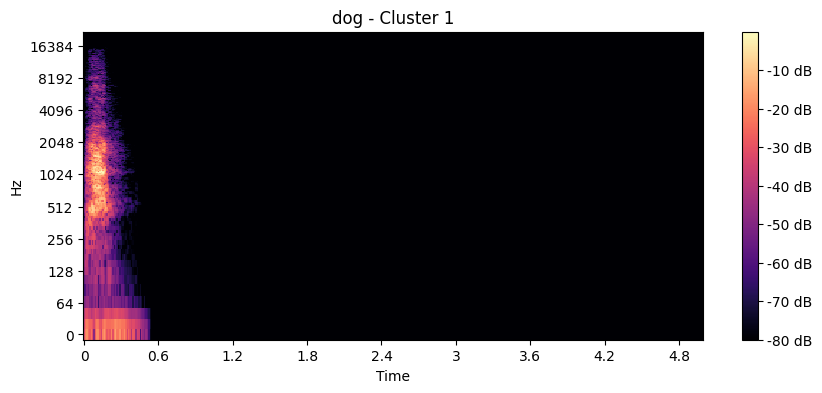

Cluster 2: ['chirping_birds']


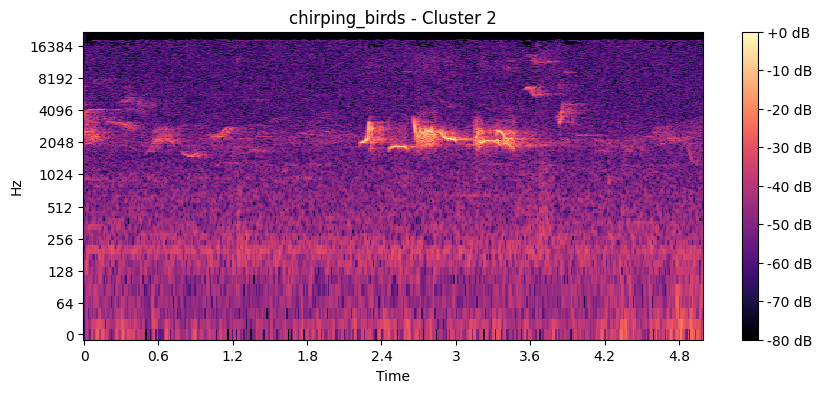

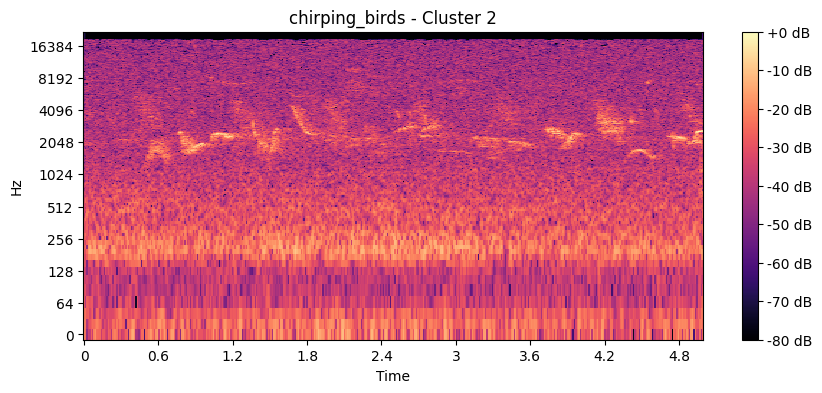

Cluster 3: ['chirping_birds' 'cat' 'dog']


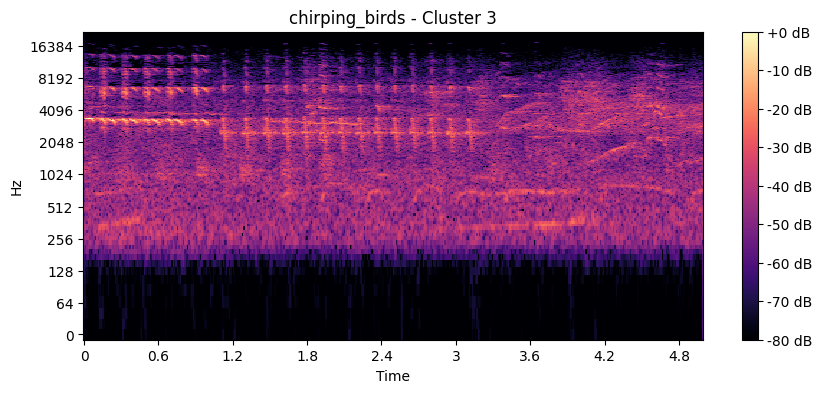

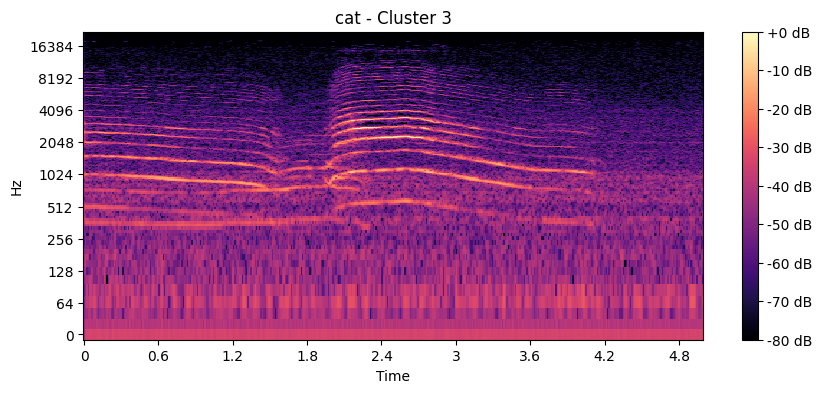

Conclusions:
1. Sound clustering: Sounds from different categories such as 'dog', 'chirping_birds', 'cat', and 'forest' are successfully clustered into separate groups, indicating effective feature extraction from audio files.
2. Classification quality: Comparing clustering results with true labels shows that clustering maintains clear distinctions between sounds from different categories. However, some mixing of categories in clusters can be observed, indicating potential areas for improvement.
3. Opportunities for improvement: Experimenting with clustering hyperparameters, such as the number of clusters, distance methods, and feature scaling, can help improve the accuracy and quality of clustering, reducing cases where categories are mixed in the same cluster.
4. Fourier transform and pooling: Using the Fourier transform to extract frequency features, as well as applying pooling to reduce the size of spectrograms, significantly improves clustering efficiency while preserving key info

In [1]:
import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler
from urllib.request import urlretrieve
from IPython.display import Audio
import zipfile
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Downloading and extracting the dataset
url = "https://github.com/karoldvl/ESC-50/archive/master.zip"
zip_file_path = "ESC-50-master.zip"
download_path = "./ESC-50-master/"
if not os.path.exists(download_path):
    urlretrieve(url, zip_file_path)
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("./")
    os.remove(zip_file_path)

# Checking the structure after extraction
!ls -R ./ESC-50-master/

# Loading metadata
metadata_path = './ESC-50-master/meta/esc50.csv'
df = pd.read_csv(metadata_path)

# Selecting sounds with labels 'dog', 'chirping_birds', 'cat', and 'forest'
selected_labels = ['dog', 'chirping_birds', 'cat', 'forest']  # Expanded selection
filtered_df = df[df['category'].isin(selected_labels)].reset_index(drop=True)

# Function to generate a spectrogram
def generate_spectrogram(file_path, n_fft=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    return spectrogram, sr

# Function to reduce the size of the spectrogram (pooling)
def pooling(spectrogram, pool_size=(2, 2)):
    pooled = spectrogram[:len(spectrogram) // pool_size[0] * pool_size[0], :len(spectrogram[0]) // pool_size[1] * pool_size[1]]
    return pooled.reshape(pooled.shape[0] // pool_size[0], pool_size[0], -1, pool_size[1]).mean(axis=(1, 3))

# Processing all sounds
spectrograms = []
labels = []
for _, row in filtered_df.iterrows():
    file_path = os.path.join(download_path, "audio", row['filename'])
    spectrogram, sr = generate_spectrogram(file_path)
    pooled_spectrogram = pooling(spectrogram)
    flattened_spectrogram = pooled_spectrogram.flatten()
    spectrograms.append(flattened_spectrogram)
    labels.append(row['category'])

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(spectrograms)

# Encoding labels into numeric values
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

# Clustering using SpectralClustering
n_clusters = len(selected_labels)
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
cluster_labels = clustering.fit_predict(scaled_data)

# Evaluating clustering
print("Classification:")
print(classification_report(numeric_labels, cluster_labels, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(numeric_labels, cluster_labels))

# Adding clustering results to DataFrame
filtered_df['cluster'] = cluster_labels

# Visualizing spectrograms for a few records from each cluster
for cluster_id in range(n_clusters):
    cluster_subset = filtered_df[filtered_df['cluster'] == cluster_id]
    print(f"Cluster {cluster_id}: {cluster_subset['category'].unique()}")
    for _, row in cluster_subset.head(2).iterrows():
        file_path = os.path.join(download_path, "audio", row['filename'])
        y, sr = librosa.load(file_path, sr=None)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max), sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"{row['category']} - Cluster {cluster_id}")
        plt.show()

# Conclusions
print("Conclusions:")
print("1. Sound clustering: Sounds from different categories such as 'dog', 'chirping_birds', 'cat', and 'forest' are successfully clustered into separate groups, indicating effective feature extraction from audio files.")
print("2. Classification quality: Comparing clustering results with true labels shows that clustering maintains clear distinctions between sounds from different categories. However, some mixing of categories in clusters can be observed, indicating potential areas for improvement.")
print("3. Opportunities for improvement: Experimenting with clustering hyperparameters, such as the number of clusters, distance methods, and feature scaling, can help improve the accuracy and quality of clustering, reducing cases where categories are mixed in the same cluster.")
print("4. Fourier transform and pooling: Using the Fourier transform to extract frequency features, as well as applying pooling to reduce the size of spectrograms, significantly improves clustering efficiency while preserving key information for further processing.")
print("5. Evaluation of results: While clustering shows good results for the main categories, it may be useful to further explore other metrics, such as accuracy and macro average, to obtain a more detailed evaluation of the results.")
print("These conclusions will help you better understand how your model works with audio data and what can be improved in further experiments.")